In [1]:
import jax
from jax import jit
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device",jax.devices()[1])
import numpy as np
import jax.numpy as jnp

# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
)

from KernelTools import diagpart

from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF,
    get_anisotropic_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k
from KernelTools import vectorize_kfunc

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# coeffs of Burgers eqn
kappa = 0.01
alpha = 0.5
# IC
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

# solve Burgers eqn
u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999
                        )
)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2889.80it/s]


In [3]:
# size of coll grid
num_grid_x, num_grid_t = 26, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

# coll grid
tx_all = jnp.vstack([tx_bdy,tx_int])
# u vals at coll grid
u_all = u_true_function(tx_all)

# idx for IC
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
# idx for FC
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
# idx for IC + FC
tx_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
# obs grid
tx_obs = jnp.vstack([tx_bdy,tx_int[tx_sample_inds]])
# u vals at obs grid
u_obs = u_true_function(tx_obs)

In [4]:
# fine grid
num_fine_grid = 200
t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
# u vals at fine grid
u_true = u_true_function(tx_fine)

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

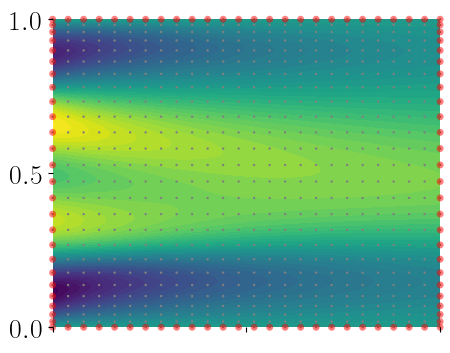

In [5]:
# u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 50, 
                vmin=-0.4532246910384856, 
                vmax=0.36374402)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 

In [6]:
# x fine grid
xfine = jnp.linspace(0,1,num_fine_grid)
# u vals at fine grid at IC
u_true_IC = u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
u_true_FC = u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

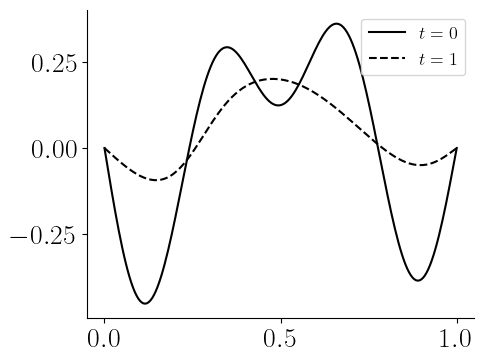

In [7]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine,u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper right",fontsize = 13)

In [8]:
# u basis ops
u_operators = (eval_k,dx_k,dt_k,dxx_k)
# L ops
feature_operators = (eval_k,dx_k,dxx_k)
# u kernel
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,100])))
# u RKHS 
u_model = CholInducedRKHS(tx_all,
                          u_operators,
                          k_u,
                          nugget_size = 1e-8
)
# u fitted params
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)
# L's at u
grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)
# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(2,
                                      grid_features_init,
                                      c=1.,
                                      scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return 10*k_P_u_part(x[2:],y[2:])
# P RKHS
P_model = OperatorModel(k_P)

# u and P object
EqnModel = OperatorPDEModel(P_model,
                            (u_model,),
                            (tx_obs,),
                            (u_obs,),
                            (tx_int,),
                            feature_operators,
                            rhs_operator=dt_k,
                            datafit_weight = 100
)

In [9]:
# u_pred vals at fine grid
u_pred = u_model.point_evaluate(tx_fine,u_params_init)

# u error at fine grid
print(get_nrmse(u_true,u_pred))

0.29978491889873415


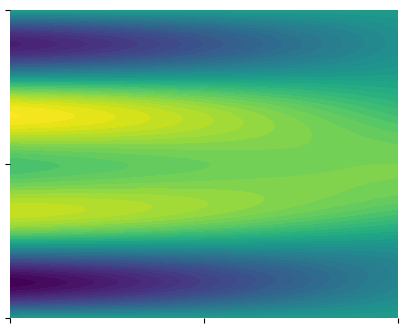

In [10]:
# u_pred plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_pred,
                levels= 50, 
                vmin=-0.4532246910384856, 
                vmax=0.36374402)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('onlydbry_u_pred_interp.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

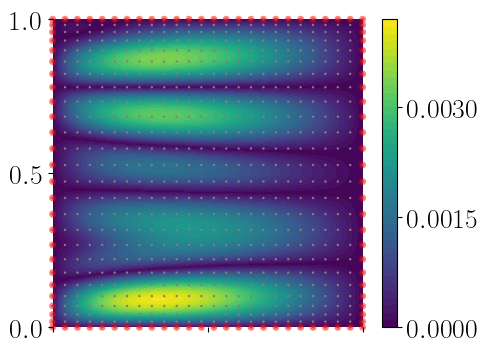

In [11]:
# u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(u_true - u_pred)/jnp.linalg.norm(u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_xticklabels([]) 

# save fig
plt.savefig('onlydbry_u_error_interp.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

### Testing on new IC

In [12]:
# new IC
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0
# solve Burgers with new IC
new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,
                       kappa = kappa,
                       alpha = alpha,
                       k_timestep=0.0001,
                       n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 3010.87it/s]


In [13]:
def get_u_pde_adj(u0_new):
    # Phat of 2 step method
    @jit
    def get_pred_ut_2step(input_features):
        init_P_features = EqnModel.single_eqn_features(u_model,u_params_init,tx_int)
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
        return P_model.predict_new(input_features,init_P_features,P_params_naive)

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut_2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_params_init

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,PdeModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj 

In [14]:
# solve Burgers with new IC 
new_u_params = get_u_pde_adj(new_u_true_function)

  1%|          | 3/251 [00:17<18:51,  4.56s/it]  

Iteration 0, loss = 1.992e-07, gradnorm = 139.8, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 8.121e-08, gradnorm = 2.892e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 5.368e-08, gradnorm = 5.598e-07, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 4.167e-08, gradnorm = 3.134e-07, alpha = 0.02411, improvement_ratio = 1.0


  3%|▎         | 7/251 [00:17<05:21,  1.32s/it]

Iteration 4, loss = 3.405e-08, gradnorm = 2.036e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.825e-08, gradnorm = 1.492e-07, alpha = 0.01674, improvement_ratio = 1.0


  0%|          | 1/201 [00:15<52:57, 15.89s/it]

Iteration 0, loss = 1.688e-09, gradnorm = 1.067e-08, alpha = 0.0004717, improvement_ratio = 1.006


In [15]:
# new_u vals at fine grid
new_u_true = new_u_true_function(tx_fine)

# new_u_pred vals at fine grid
new_u_pred = u_model.point_evaluate(tx_fine,new_u_params)

print(get_nrmse(new_u_true,new_u_pred))

0.5461647554043612


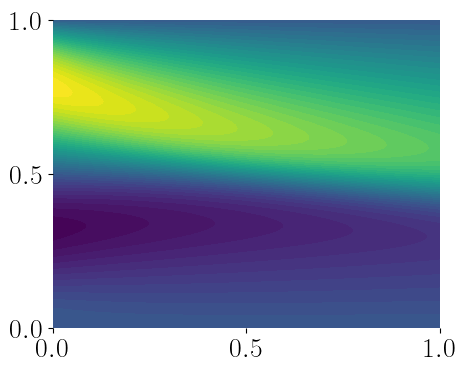

In [16]:
# new_u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, new_u_true,
                levels= 50)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)

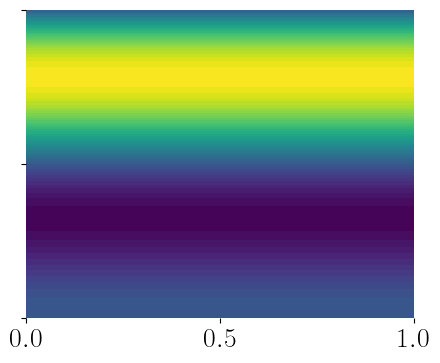

In [17]:
# new_u_pred plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, new_u_pred,
                levels= 50)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_newIC_u_pred_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

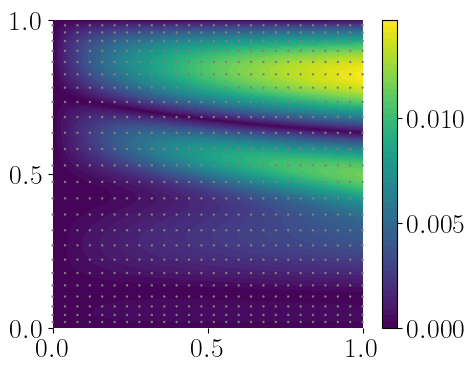

In [18]:
# new_u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(new_u_true - new_u_pred)/jnp.linalg.norm(new_u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_int.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# save fig
plt.savefig('onlydbry_newIC_u_error_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [19]:
# store data
data = {'tx_obs': tx_obs,
        'tx_all': tx_all,
        'tx_int': tx_int,
        'tx_bdy': tx_bdy,
        'tx_fine': tx_fine,
        'xfine': xfine,
        'u_true': u_true,
        'u_pred': u_pred,
        'u_true_IC': u_true_IC,
        'u_true_FC': u_true_FC,
        'new_u_true': new_u_true,
        'new_u_pred': new_u_pred
}

In [20]:
# save data
np.save('data.npy', np.array(data, dtype=object), allow_pickle=True)